# ACS in Mountain Car environment

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import random
import pickle

import gym

import pandas as pd
import numpy as np

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../'))

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.metrics import population_metrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

## TODO
- ✅ https://www.youtube.com/watch?v=rBzOyjywtPw
- ✅ https://repl.it/@MichaelMegliola/MountainCarQ-argmax-only
- https://en.wikipedia.org/wiki/Learned_helplessness
- maybe some projection of the input space for simpler problem
- ✅explore / exploit decay
- car final position metric
- ✅policy visualization (2d plot)?
- extend mountain car to return energy as reward
- ✅classifiers plot
- profiler co działa najbardziej spowalnia

In [7]:
trials = 50
decay = False
bins = 14

## Environment
Description - https://github.com/openai/gym/wiki/MountainCar-v0

![aa](http://gym.openai.com/v2018-02-21/videos/MountainCar-v0-270f34b9-f23e-4d95-a933-4c902b4f4435/poster.jpg)

In [2]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

_range, _low = (env.observation_space.high - env.observation_space.low, env.observation_space.low)

## Agent configuration

### Discretization of continuous input
Values for bins are taken from https://gist.github.com/vblank182/83e29f16755320f82936d211761bfeea

In [3]:
class MountainCarAdapter(EnvironmentAdapter):
    BINS = bins
    
    @classmethod
    def to_genotype(cls, obs):
        return np.round(((obs - _low) / _range) * cls.BINS).astype(int).astype(str)

### Fitness function
Energy approach is tested. But.... what to do with the wildcard?

In [4]:
def energy(cl):
    # object energy is calculated like postition * velocity. We favour when it's closer to the right side and moving faster        
    return int(cl.condition[0]) * int(cl.condition[1])

### Evaluation metric

In [5]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])

# collect more metrics
def mc_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

### Building final configuration object

In [6]:
cfg = Configuration(
            classifier_length=2,
            number_of_possible_actions=3,
            epsilon=1.0,
            beta=0.2,
            gamma=0.95,
            theta_exp=100,
            theta_ga=50,
            do_ga=True,
            mu=0.03,
            u_max=2,
            metrics_trial_frequency=5,
            user_metrics_collector_fcn=mc_metrics,
            environment_adapter=MountainCarAdapter)

## Experiments

In [8]:
print(f'Running {trials} trials, decay={decay}, bins={bins}')

Running 50 trials, decay=False


In [9]:
%%time

agent = ACS2(cfg)
population, metrics = agent.explore(env, trials, decay=decay)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1000, 'reward': -1.0, 'avg_fitness': -1.165528375963443, 'population': 367, 'numerosity': 523, 'reliable': 38}
INFO:lcs.agents.Agent:{'trial': 5, 'steps_in_trial': 1000, 'reward': -1.0, 'avg_fitness': -1.207192173378042, 'population': 367, 'numerosity': 874, 'reliable': 51}
INFO:lcs.agents.Agent:{'trial': 10, 'steps_in_trial': 1000, 'reward': -1.0, 'avg_fitness': -1.134927721111107, 'population': 370, 'numerosity': 1347, 'reliable': 63}
INFO:lcs.agents.Agent:{'trial': 15, 'steps_in_trial': 1000, 'reward': -1.0, 'avg_fitness': -1.1284117137335992, 'population': 366, 'numerosity': 1446, 'reliable': 57}
INFO:lcs.agents.Agent:{'trial': 20, 'steps_in_trial': 1000, 'reward': -1.0, 'avg_fitness': -1.145636209002594, 'population': 365, 'numerosity': 1456, 'reliable': 54}
INFO:lcs.agents.Agent:{'trial': 25, 'steps_in_trial': 1000, 'reward': -1.0, 'avg_fitness': -1.1727717104469277, 'population': 353, 'numerosity': 1486, 'reliable': 62}
INFO:l

CPU times: user 1min, sys: 492 ms, total: 1min
Wall time: 1min 5s


In [10]:
# helper function for printing classifier details
def print_cl(cl):
    action = None
    marked = ''
    
    if cl.action == 0:
        action = 'L'
    if cl.action == 1:
        action = '-'
    if cl.action == 2:
        action = 'R'
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, q: {cl.q:.2f}, exp: {cl.exp}, num: {cl.num} {marked}]")

In [11]:
reliable = [cl for cl in population if cl.is_reliable()]

print(f"Explore population size: {len(population)}")
print(f"Reliable classifiers: {len(reliable)}\n")

for cl in sorted(reliable, key=lambda cl: -cl.fitness)[:50]:
    print(print_cl(cl))

Explore population size: 346
Reliable classifiers: 59

67 - L - ## [fit: -1.007, r: -1.01, q: 0.99, exp: 3600, num: 19 ]
57 - - - ## [fit: -1.017, r: -1.02, q: 1.00, exp: 7109, num: 19 ]
57 - R - ## [fit: -1.019, r: -1.03, q: 0.99, exp: 7970, num: 16 ]
#7 - R - ## [fit: -1.023, r: -1.02, q: 1.00, exp: 16, num: 1 ]
54 - L - ## [fit: -1.055, r: -1.15, q: 0.91, exp: 8, num: 5 ]
610 - R - ## [fit: -1.059, r: -1.16, q: 0.92, exp: 3, num: 2 ]
29 - - - #10 [fit: -1.064, r: -1.16, q: 0.92, exp: 2, num: 2 ]
65 - L - ## [fit: -1.068, r: -1.18, q: 0.91, exp: 48, num: 19 ]
64 - R - 55 [fit: -1.069, r: -1.17, q: 0.92, exp: 1, num: 1 ]
711 - L - 810 [fit: -1.071, r: -1.17, q: 0.92, exp: 1, num: 1 ]
810 - - - ## [fit: -1.086, r: -1.15, q: 0.94, exp: 2, num: 3 ]
87 - L - ## [fit: -1.089, r: -1.14, q: 0.96, exp: 15, num: 8 ]
67 - R - ## [fit: -1.089, r: -1.09, q: 1.00, exp: 3315, num: 19 ]
99 - - - ## [fit: -1.096, r: -1.16, q: 0.94, exp: 4, num: 2 ]
54 - R - ## [fit: -1.105, r: -1.16, q: 0.96, exp: 13

In [12]:
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('trial', inplace=True)

metrics_df.head()

,steps_in_trial,reward,avg_fitness,population,numerosity,reliable
trial,,,,,,
0,1000,-1.0,-1.165528,367,523,38
5,1000,-1.0,-1.207192,367,874,51
10,1000,-1.0,-1.134928,370,1347,63
15,1000,-1.0,-1.128412,366,1446,57
20,1000,-1.0,-1.145636,365,1456,54


### Steps in trial

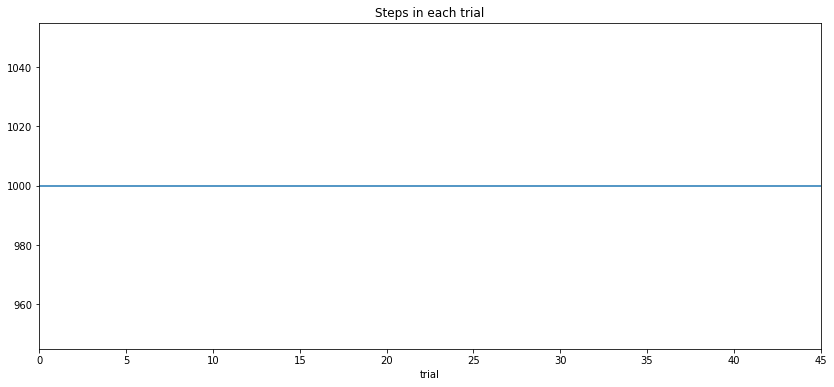

In [13]:
metrics_df['steps_in_trial'].plot(figsize=(14,6), title='Steps in each trial');

### Average fitness
Lower is better

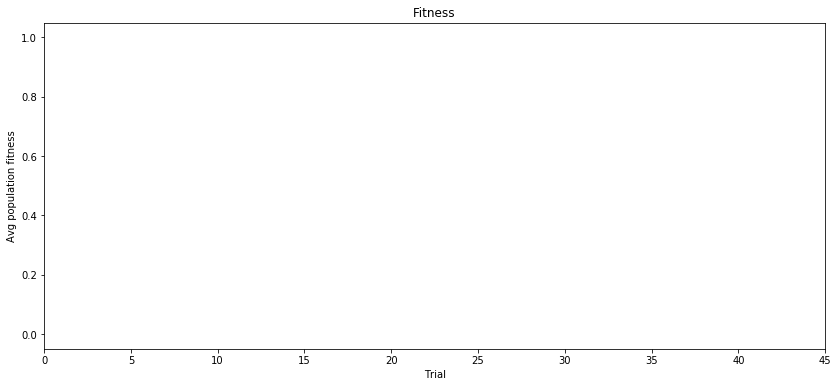

In [14]:
window = 50

fig, ax = plt.subplots(figsize=(14, 6))

metrics_df['avg_fitness'].rolling(window=window).mean().plot(ax=ax)

ax.set_title('Fitness')
ax.set_xlabel('Trial')
ax.set_ylabel('Avg population fitness')

plt.show()

## Classifiers

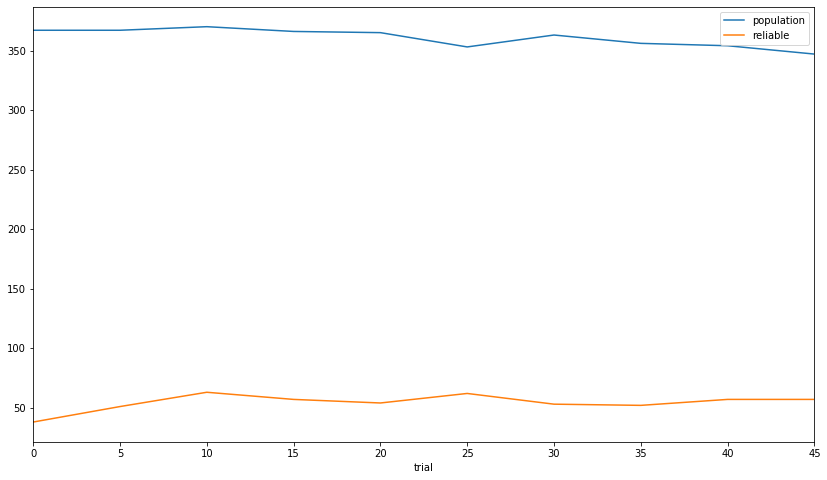

In [15]:
fig, ax = plt.subplots(figsize=(14,8))

metrics_df['population'].plot(label='population', ax=ax)
metrics_df['reliable'].plot(label='reliable', ax=ax)

plt.legend()
plt.show()

## Policy plot

In [16]:
obs = ("1","1")

def best_action(obs, population):
    matchset = population.form_match_set(Perception(obs))
    anticipated_change_cls = [cl for cl in matchset if cl.does_anticipate_change()]

    best_classifier = None
    if len(anticipated_change_cls) > 0:
        random.shuffle(anticipated_change_cls)
        best_classifier = max(anticipated_change_cls, key=lambda cl: cl.fitness * cl.num)

    if best_classifier is not None:
        return best_classifier.action
    else:
        return None
    
a = best_action(obs, population)
print(a)

2


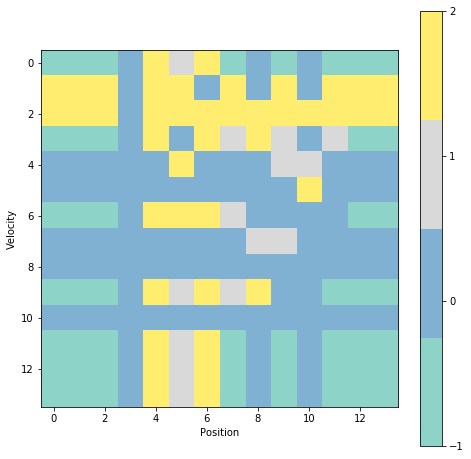

In [17]:
cmap = cm.get_cmap('Set3', 4)

BINS = 14
EMPTY = -1

policy = np.full((BINS, BINS), EMPTY)

for pos_bin in range(BINS):
    for vel_bin in range(BINS):
        obs = (str(pos_bin), str(vel_bin))
        action = best_action(obs, population)
        policy[pos_bin, vel_bin] = action if action != None else EMPTY
        
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(policy, interpolation='none', cmap=cmap);

fig.colorbar(im, ticks=[-1, 0, 1, 2])
plt.xlabel('Position')
plt.ylabel('Velocity')

plt.show();

## Save objects for reproduction

In [18]:
filename = f'mountain_car_{trials}_trials_decay_{decay}_bins_{bins}.pickle'
with open(filename, 'wb') as f:
    pickle.dump((population, metrics_df), f)